## TEAM MEMBERS:
1. ME20B083
2. ME20B138


# MC REINFORCE - CARTPOLE V1

IMPORTING LIBRARIES

In [1]:
'''
Installing packages for rendering the game on Colab
'''

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1
!pip install gym[classic_control]

  Using cached pygame-2.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)


In [2]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


In [3]:
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
''''
Function to load environment
'''
def LoadingEnv(seed = 0,name = 'CartPole-v1'):
  env = gym.make(name)
  env.seed(seed)
  state_shape = env.observation_space.shape[0]
  no_of_actions = env.action_space.n
  return env,state_shape, no_of_actions

NETWORK FOR J(θ)

In [5]:
device  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
'''
### Q Network & Some 'hyperparameters'

QNetwork1:
Input Layer - 4 nodes (State Shape) \
Hidden Layer 1 - 128 nodes \
Hidden Layer 2 - 64 nodes \
Output Layer - 2 nodes (Action Space) \
Optimizer - zero_grad()
'''

import torch
import torch.nn as nn
import torch.nn.functional as F


'''
Bunch of Hyper parameters
'''

GAMMA = 0.99            # discount factor
LR = 5e-4               # learning rate


'''
similar to Qnetwork , for MC reinforce we have Jnetwork
'''

class JNetwork(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(JNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

MC REINFORCE AGENT - TYPE 1

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import datetime
import gym

'''
CREATING REINFORCE agent
'''
class REINFORCEAgentType1():
    def __init__(self, state_size, action_size, seed,fc1_units,fc2_units,lr=0.01):
        # PARAMETERS OF AGENT
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # CREATE A NETWORK
        self.policy_network = JNetwork(state_size, action_size, seed,fc1_units,fc2_units).to(device)
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=lr)


        self.saved_log_probs = []
        self.rewards = []
        self.states  =[]

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        logits = self.policy_network(state)

        # WE USE SOFTMAX FOR REINFORCE
        probs = torch.softmax(logits, dim=1)

        # USING TORCH CATEGORICAL DISTRUBTION FOR SMAPLING USING SOFTMAX WEIGHTS
        m = torch.distributions.Categorical(probs)
        action = m.sample()

        # STORING LOG OF OUTPUT POLICY
        self.saved_log_probs.append(m.log_prob(action))

        # RETURNING ACTION
        return action.item()

    def learn(self, gamma):

        # FINDING G(t)
        G = []
        for t in range(len(self.rewards)):
          rewards_t  = self.rewards[t:]
          discounts_t = [gamma ** i for i in range(len(rewards_t) + 1)]
          G.append(sum([a * b for a, b in zip(discounts_t,rewards_t)]))

        policy_loss = []
        for t,log_prob in enumerate(self.saved_log_probs):
            policy_loss.append(-log_prob * G[t])
        policy_loss = torch.cat(policy_loss).sum()

        # doing gradient descent( we need gradient ascent so we use -log_loss as loss)
        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()


        # RESERTING CONTAINERS
        self.saved_log_probs = []
        self.rewards = []
        self.states = []


ME REINFORCE TYPE II

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import datetime
import gym

# Define the neural network architecture
class BNetwork(nn.Module):
    def __init__(self, input_size, output_size, seed, fc1_units=128, fc2_units=64):
        super(BNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(input_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Define the REINFORCE agent with baseline
class REINFORCEAgentType2():
    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64, lr1=0.01, lr2=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Policy network
        self.policy_network = JNetwork(state_size, action_size, seed, fc1_units, fc2_units).to(device)
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=lr1)

        # Baseline network (state-value function)
        self.baseline_network = BNetwork(state_size, 1, seed, fc1_units, fc2_units).to(device)
        self.baseline_optimizer = optim.Adam(self.baseline_network.parameters(), lr=lr2)

        self.saved_log_probs = []
        self.rewards = []
        self.states = []

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        logits = self.policy_network(state)
        probs = torch.softmax(logits, dim=1)
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        self.saved_log_probs.append(m.log_prob(action))
        return action.item()

    def learn(self, gamma):
        G = []
        for t in range(len(self.rewards)):
            rewards_t = self.rewards[t:]
            discounts_t = [gamma ** i for i in range(len(rewards_t) + 1)]
            G.append(sum([a * b for a, b in zip(discounts_t, rewards_t)]))
        value_loss = []
        for t in range(len(G)-1):
          state = torch.from_numpy(self.states[t]).float().unsqueeze(0).to(device)
          next_state = torch.from_numpy(self.states[t+1]).float().unsqueeze(0).to(device)
          reward = torch.tensor(self.rewards[t], dtype=torch.float32)
          # Compute TD(0) error
          target = reward + gamma * self.baseline_network(next_state)
          prediction = self.baseline_network(state)
          td_error = target - prediction
          # Compute loss and update the value network
          loss = td_error ** 2
          value_loss.append(loss)


        value_loss = torch.cat(value_loss).sum()
        self.baseline_optimizer.zero_grad()
        value_loss.backward()
        self.baseline_optimizer.step()

        policy_loss = []
        for t, log_prob in enumerate(self.saved_log_probs):
            state = torch.from_numpy(self.states[t]).float().unsqueeze(0).to(device)
            advantage = G[t] - self.baseline_network(state)  # Use the same delta calculated for baseline update
            policy_loss.append(-log_prob * advantage)
        policy_loss = torch.cat(policy_loss).sum()

        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()

        # Reset containers
        self.saved_log_probs = []
        self.rewards = []
        self.states = []

Reinforce Algorithm

In [9]:
# Define the REINFORCE algorithm
def ReinforceAlgo(env, agent, n_episodes=10000, max_t=1000, gamma=0.99,reward_threshold = 195, flag = True):
    scores_window = deque(maxlen=100)
    rewards_per_episode = []
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            agent.states.append(state)
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            # strong rewards for each timpestep of episode
            agent.rewards.append(reward)
            state = next_state
            # net score of episode
            score += reward
            if done:
                break

        scores_window.append(score)
        rewards_per_episode.append(score)

        agent.learn(gamma)

        if i_episode % 100 == 0:
          print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

        if flag:
          if np.mean(scores_window) >= reward_threshold:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            break

    return rewards_per_episode

Defining Hyperparamters and Running Algo

In [10]:
import torch
import numpy as np
import random
import datetime
'''
 Define hyperparameters
'''

seed = 0
LR1 = 1e-4
LR2 = 1e-4

gamma = 0.99
n_episodes = 10000
max_t = 1000
name = 'CartPole-v1'
fc1_units = 128
fc2_units = 64
reward_threshold = 195
'''
 Function to set device
'''
def set_device():
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

'''
Function to run the algorithm
'''
def RunAlgo(variant,fc1_units=fc1_units, fc2_units=fc2_units, seed=seed, LR1=LR1,LR2 = LR2, gamma=gamma, n_episodes=n_episodes,max_t=max_t, name=name, reward_threshold=reward_threshold,flag = True):
    device = set_device()
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    env, state_shape, no_of_actions = LoadingEnv(seed, name)
    if variant == '1':
      agent = REINFORCEAgentType1(state_shape, no_of_actions, seed, fc1_units, fc2_units, LR1)
    else:
      agent = REINFORCEAgentType2(state_shape, no_of_actions, seed, fc1_units, fc2_units, LR1,LR2)
    begin_time = datetime.datetime.now()
    rewards = ReinforceAlgo(env, agent, n_episodes, max_t, gamma, reward_threshold,flag)
    time_taken = datetime.datetime.now() - begin_time
    print(" Time taken:", time_taken)
    env.close()
    return rewards, time_taken

In [ ]:
'''
 Define hyperparameters
'''

seed = 0
LR1 = 1e-4
LR2 = 1e-4

gamma = 0.99
n_episodes = 5000
max_t = 1000
name = 'CartPole-v1'
fc1_units = 128
fc2_units = 64
reward_threshold = 195

# Function for hyperparameter tuning
def hyperparameter_tuning(variant,params):
    results = []
    for param_set in params:
        rewards, time_taken = RunAlgo(variant,**param_set,seed= seed,gamma = gamma, LR2 = LR2, n_episodes=n_episodes,max_t=max_t, name=name, reward_threshold=reward_threshold)
        avg_score = np.mean(rewards)
        avg_time = time_taken.total_seconds()  # Convert timedelta to seconds
        results.append({
            'Hyperparameters': param_set,
            'Average Score': avg_score,
            'Training Time (s)': avg_time,
            'rewards' : rewards
        })
    return results

# Function to generate LaTeX table
def generate_latex_table(results):
    table = "\\begin{table}[h]\n\\centering\n\\begin{tabular}{|c|c|c|}\n\\hline\n"
    table += "Hyperparameters & Average Score & Training Time (s) \\\\\n\\hline\n"
    for result in results:
        table += f"{result['Hyperparameters']} & {result['Average Score']:.2f} & {result['Training Time (s)']:.2f} \\\\\n"
    table += "\\hline\n\\end{tabular}\n\\caption{Hyperparameter Tuning Results}\n\\label{tab:hyperparams}\n\\end{table}"
    return table
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Define range of hyperparameters to tune
params_to_tune = [
    {'fc1_units': 128, 'fc2_units': 64, 'LR1': 1e-6},
    {'fc1_units': 128, 'fc2_units': 64, 'LR1': 1e-1},
    {'fc1_units': 128, 'fc2_units': 64, 'LR1': 1e-4 },
    {'fc1_units': 64, 'fc2_units': 32, 'LR1': 1e-4},
    {'fc1_units': 256, 'fc2_units': 128, 'LR1': 1e-4},
    {'fc1_units': 128, 'fc2_units': 128, 'LR1': 1e-4}
]

# Perform hyperparameter tuning
results = hyperparameter_tuning('Type1',params_to_tune)

# Generate LaTeX table
latex_table = generate_latex_table(results)

# Print LaTeX table
print(latex_table)

Episode 100	Average Score: 23.91
Episode 200	Average Score: 21.84
Episode 300	Average Score: 20.36
Episode 400	Average Score: 21.59
Episode 500	Average Score: 20.93
Episode 600	Average Score: 21.25
Episode 700	Average Score: 21.65
Episode 800	Average Score: 20.44
Episode 900	Average Score: 18.57
Episode 1000	Average Score: 22.03
Episode 1100	Average Score: 20.18
Episode 1200	Average Score: 23.19
Episode 1300	Average Score: 21.87
Episode 1400	Average Score: 23.18
Episode 1500	Average Score: 22.26
Episode 1600	Average Score: 22.37
Episode 1700	Average Score: 21.91
Episode 1800	Average Score: 20.89
Episode 1900	Average Score: 21.95
Episode 2000	Average Score: 22.45
Episode 2100	Average Score: 22.50
Episode 2200	Average Score: 21.33
Episode 2300	Average Score: 23.20
Episode 2400	Average Score: 21.26
Episode 2500	Average Score: 22.39
Episode 2600	Average Score: 21.11
Episode 2700	Average Score: 21.02
Episode 2800	Average Score: 21.17
Episode 2900	Average Score: 21.51
Episode 3000	Average Sc

In [ ]:
'''
 Define hyperparameters
'''

seed = 0
LR1 = 1e-4
LR2 = 1e-4

gamma = 0.99
n_episodes = 5000
max_t = 1000
name = 'CartPole-v1'
fc1_units = 128
fc2_units = 64
reward_threshold = 195

# Function for hyperparameter tuning
def hyperparameter_tuning(variant,params):
    results = []
    for param_set in params:
        rewards, time_taken = RunAlgo(variant,**param_set,seed= seed,gamma = gamma, LR2 = LR2, n_episodes=n_episodes,max_t=max_t, name=name, reward_threshold=reward_threshold)
        avg_score = np.mean(rewards)
        avg_time = time_taken.total_seconds()  # Convert timedelta to seconds
        results.append({
            'Hyperparameters': param_set,
            'Average Score': avg_score,
            'Training Time (s)': avg_time,
            'rewards' : rewards
        })
    return results

# Function to generate LaTeX table
def generate_latex_table(results):
    table = "\\begin{table}[h]\n\\centering\n\\begin{tabular}{|c|c|c|}\n\\hline\n"
    table += "Hyperparameters & Average Score & Training Time (s) \\\\\n\\hline\n"
    for result in results:
        table += f"{result['Hyperparameters']} & {result['Average Score']:.2f} & {result['Training Time (s)']:.2f} \\\\\n"
    table += "\\hline\n\\end{tabular}\n\\caption{Hyperparameter Tuning Results}\n\\label{tab:hyperparams}\n\\end{table}"
    return table
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Define range of hyperparameters to tune
params_to_tune = [
    {'fc1_units': 128, 'fc2_units': 64, 'LR1': 1e-6},
    {'fc1_units': 128, 'fc2_units': 64, 'LR1': 1e-1},
    {'fc1_units': 128, 'fc2_units': 64, 'LR1': 1e-4 },
    {'fc1_units': 64, 'fc2_units': 32, 'LR1': 1e-4},
    {'fc1_units': 256, 'fc2_units': 128, 'LR1': 1e-4},
    {'fc1_units': 128, 'fc2_units': 128, 'LR1': 1e-4}
]

# Perform hyperparameter tuning
results = hyperparameter_tuning('Type 2',params_to_tune)

# Generate LaTeX table
latex_table = generate_latex_table(results)

# Print LaTeX table
print(latex_table)

\begin{table}[h]
\centering
\begin{tabular}{|c|c|c|}
\hline
Hyperparameters & Average Score & Training Time (s) \\
\hline
{'fc1_units': 128, 'fc2_units': 64, 'LR1': 1e-06} & 22.07 & 214.98 \\
{'fc1_units': 128, 'fc2_units': 64, 'LR1': 0.1} & 9.36 & 98.64 \\
{'fc1_units': 128, 'fc2_units': 64, 'LR1': 0.0001} & 75.90 & 138.54 \\
{'fc1_units': 64, 'fc2_units': 32, 'LR1': 0.0001} & 71.99 & 215.54 \\
{'fc1_units': 256, 'fc2_units': 128, 'LR1': 0.0001} & 89.15 & 122.41 \\
{'fc1_units': 128, 'fc2_units': 128, 'LR1': 0.0001} & 91.20 & 123.30 \\
\hline
\end{tabular}
\caption{Hyperparameter Tuning Results}
\label{tab:hyperparams}
\end{table}

In [ ]:
reward_threshold = 495
n_episodes = 1000
max_t = 500
name = 'CartPole-v1'
seed = 0
best_params  = {'fc1_units': 256, 'fc2_units': 128, 'LR1': 1e-4, 'LR2' : 1e-04 ,'gamma': 0.99}

In [ ]:
rewards, time_taken = RunAlgo('1',**best_params,seed= seed, n_episodes=n_episodes,max_t=max_t, name=name, reward_threshold=reward_threshold,flag = False)

Episode 100	Average Score: 25.85
Episode 200	Average Score: 39.07
Episode 300	Average Score: 49.34
Episode 400	Average Score: 71.43
Episode 500	Average Score: 135.24
Episode 600	Average Score: 166.64
Episode 700	Average Score: 196.28
Episode 800	Average Score: 228.75
Episode 900	Average Score: 284.63
Episode 1000	Average Score: 275.85
 Time taken: 0:02:56.438475


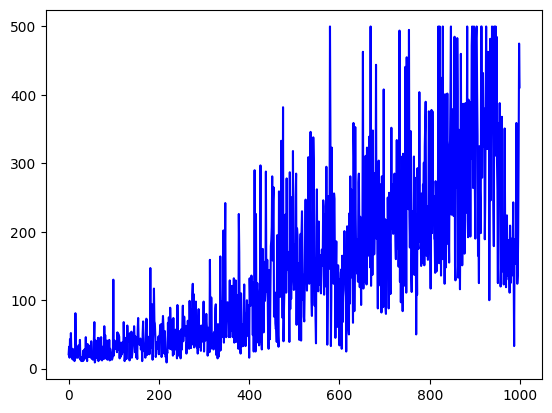

In [ ]:
plt.plot(rewards, label='Mean Rewards', color='blue')
plt.show()

Episode 100	Average Score: 27.18
Episode 200	Average Score: 37.85
Episode 300	Average Score: 50.79
Episode 400	Average Score: 69.30
Episode 500	Average Score: 95.65
Episode 600	Average Score: 160.46
Episode 700	Average Score: 202.87
Episode 800	Average Score: 288.62
Episode 900	Average Score: 334.61
Episode 1000	Average Score: 353.97
 Time taken: 0:05:59.536264


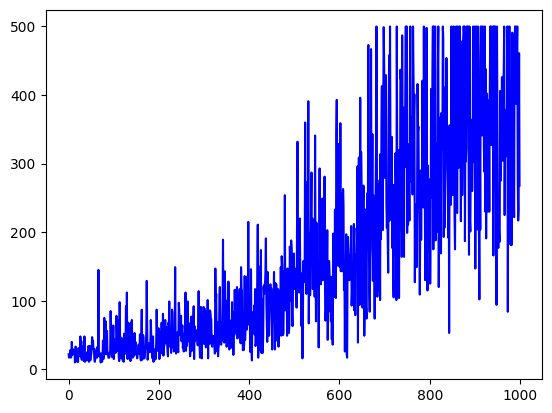

In [ ]:
reward_threshold = 495
n_episodes = 1000
max_t = 500
name = 'CartPole-v1'
seed = 0
best_params  = {'fc1_units': 256, 'fc2_units': 128, 'LR1': 1e-4,'LR2' : 1e-04 ,'gamma': 0.99}
rewards, time_taken = RunAlgo('2',**best_params,seed= seed, n_episodes=n_episodes,max_t=max_t, name=name, reward_threshold=reward_threshold,flag = False)
plt.plot(rewards, label='Mean Rewards', color='blue')
plt.show()

Episode 100	Average Score: 25.85
Episode 200	Average Score: 39.07
Episode 300	Average Score: 49.34
Episode 400	Average Score: 71.43
Episode 500	Average Score: 135.24
Episode 600	Average Score: 166.64
Episode 700	Average Score: 196.28
Episode 800	Average Score: 228.75
Episode 900	Average Score: 284.63
Episode 1000	Average Score: 275.85
Episode 1100	Average Score: 346.46
Episode 1200	Average Score: 305.76
Episode 1300	Average Score: 292.57
Episode 1400	Average Score: 388.00
Episode 1500	Average Score: 400.33
Episode 1600	Average Score: 325.43
Episode 1700	Average Score: 328.96
Episode 1800	Average Score: 389.36
Episode 1900	Average Score: 357.60
Episode 2000	Average Score: 211.08
Episode 2100	Average Score: 180.14
Episode 2200	Average Score: 163.20
Episode 2300	Average Score: 255.90
Episode 2400	Average Score: 325.64
Episode 2500	Average Score: 407.87
Episode 2600	Average Score: 445.03
Episode 2700	Average Score: 475.07
Episode 2800	Average Score: 457.90
Episode 2900	Average Score: 466.3

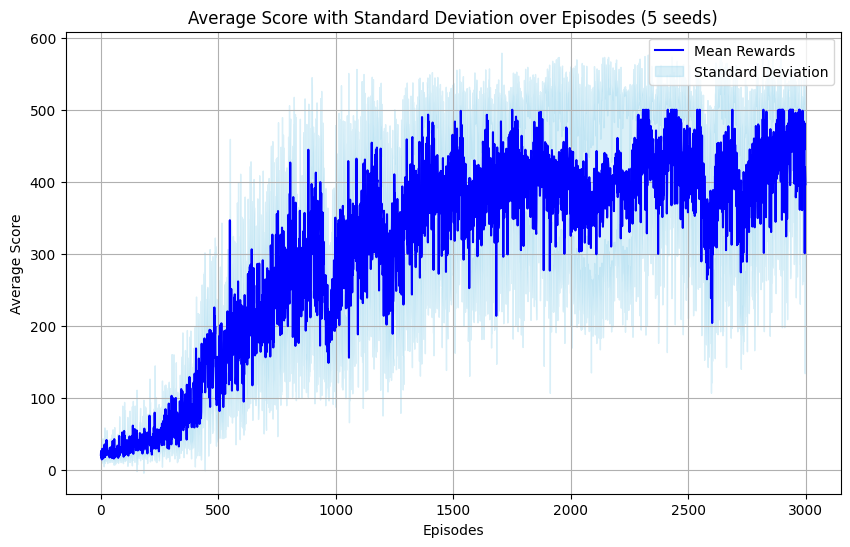

In [11]:
import numpy as np
import matplotlib.pyplot as plt
reward_threshold = 495
n_episodes = 3000
max_t = 500
name = 'CartPole-v1'
seed = 0
best_params  = {'fc1_units': 256, 'fc2_units': 128, 'LR1': 1e-4,'LR2' : 1e-04 ,'gamma': 0.99}
# Define function to run algorithm over multiple seeds
def run_multiple_seeds(num_seeds=5):
    all_rewards = []
    all_time_taken = []
    for i in range(num_seeds):
        seed = i
        rewards, time_taken =  RunAlgo('1',**best_params,seed= seed, n_episodes=n_episodes,max_t=max_t, name=name, reward_threshold=reward_threshold,flag = False)
        all_rewards.append(rewards)
        all_time_taken.append(time_taken.total_seconds())
    return all_rewards, all_time_taken

# Run the algorithm over multiple seeds
all_rewards, all_time_taken = run_multiple_seeds()

# Calculate mean and standard deviation of rewards
mean_rewards_1 = np.mean(all_rewards, axis=0)
std_rewards_1 = np.std(all_rewards, axis=0)
upper_bound_1 = mean_rewards_1 + std_rewards_1
lower_bound_1 = mean_rewards_1 - std_rewards_1

# Plot rewards mean along with upper and lower bounds based on standard deviation
plt.figure(figsize=(10, 6))
plt.plot(mean_rewards_1, label='Mean Rewards', color='blue')
plt.fill_between(range(len(mean_rewards_1)), lower_bound_1, upper_bound_1, color='skyblue', alpha=0.3, label='Standard Deviation')
plt.xlabel('Episodes')
plt.ylabel('Average Score')
plt.title('Average Score with Standard Deviation over Episodes (5 seeds)')
plt.legend()
plt.grid(True)
plt.show()


Episode 100	Average Score: 27.18
Episode 200	Average Score: 37.85
Episode 300	Average Score: 50.79
Episode 400	Average Score: 69.30
Episode 500	Average Score: 95.65
Episode 600	Average Score: 160.46
Episode 700	Average Score: 202.87
Episode 800	Average Score: 288.62
Episode 900	Average Score: 334.61
Episode 1000	Average Score: 353.97
Episode 1100	Average Score: 374.66
Episode 1200	Average Score: 367.18
Episode 1300	Average Score: 384.85
Episode 1400	Average Score: 401.78
Episode 1500	Average Score: 425.86
Episode 1600	Average Score: 423.20
Episode 1700	Average Score: 450.82
Episode 1800	Average Score: 426.35
Episode 1900	Average Score: 477.88
Episode 2000	Average Score: 466.55
Episode 2100	Average Score: 436.78
Episode 2200	Average Score: 471.16
Episode 2300	Average Score: 378.55
Episode 2400	Average Score: 453.19
Episode 2500	Average Score: 474.21
Episode 2600	Average Score: 451.29
Episode 2700	Average Score: 472.61
Episode 2800	Average Score: 424.15
Episode 2900	Average Score: 480.90

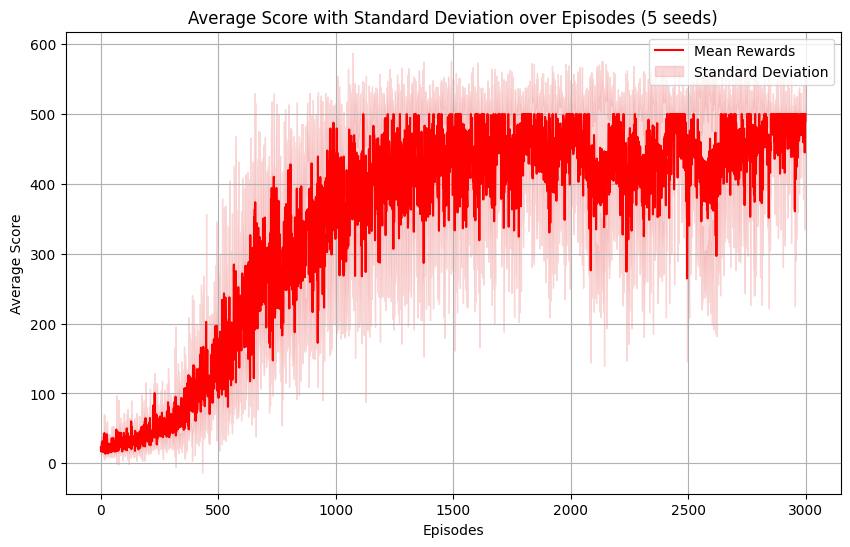

In [12]:
import numpy as np
import matplotlib.pyplot as plt
reward_threshold = 495
n_episodes = 3000
max_t = 500
name = 'CartPole-v1'
seed = 0
best_params  = {'fc1_units': 256, 'fc2_units': 128, 'LR1': 1e-4,'LR2' : 1e-04 ,'gamma': 0.99}
# Define function to run algorithm over multiple seeds
def run_multiple_seeds(num_seeds=2):
    all_rewards = []
    all_time_taken = []
    for i in range(num_seeds):
        seed = i
        rewards, time_taken =  RunAlgo('2',**best_params,seed= seed, n_episodes=n_episodes,max_t=max_t, name=name, reward_threshold=reward_threshold,flag = False)
        all_rewards.append(rewards)
        all_time_taken.append(time_taken.total_seconds())
    return all_rewards, all_time_taken

# Run the algorithm over multiple seeds
all_rewards, all_time_taken = run_multiple_seeds()

# Calculate mean and standard deviation of rewards
mean_rewards_2 = np.mean(all_rewards, axis=0)
std_rewards_2 = np.std(all_rewards, axis=0)
upper_bound_2 = mean_rewards_2 + std_rewards_2
lower_bound_2 = mean_rewards_2 - std_rewards_2

# Plot rewards mean along with upper and lower bounds based on standard deviation
plt.figure(figsize=(10, 6))
plt.plot(mean_rewards_2, label='Mean Rewards', color='red')
plt.fill_between(range(len(mean_rewards_2)), lower_bound_2, upper_bound_2, color='lightcoral', alpha=0.3, label='Standard Deviation')
plt.xlabel('Episodes')
plt.ylabel('Average Score')
plt.title('Average Score with Standard Deviation over Episodes (5 seeds)')
plt.legend()
plt.grid(True)
plt.show()


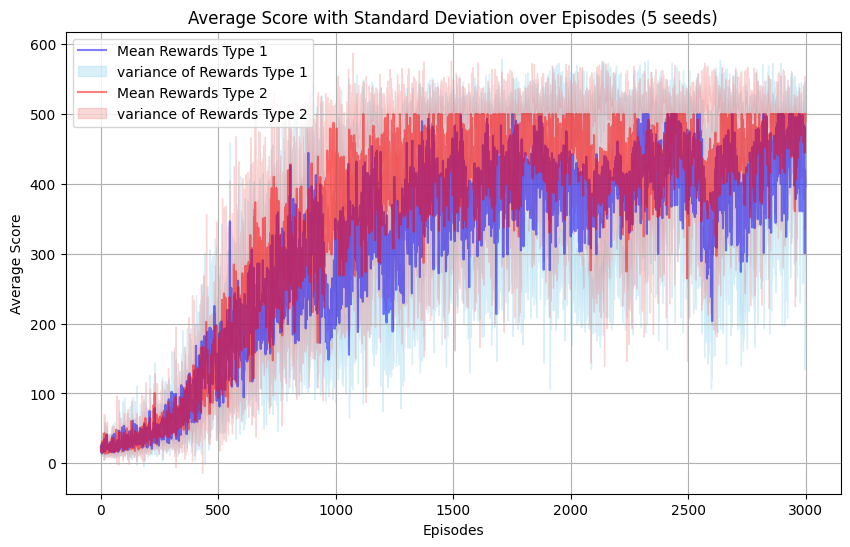

In [15]:
# Plot rewards mean along with upper and lower bounds based on standard deviation
plt.figure(figsize=(10, 6))
plt.plot(mean_rewards_1, label='Mean Rewards Type 1', color='blue',alpha=0.5)
plt.fill_between(range(len(mean_rewards_1)), lower_bound_1, upper_bound_1, color='skyblue', alpha=0.3,label='variance of Rewards Type 1')
plt.plot(mean_rewards_2, label='Mean Rewards Type 2', color='red',alpha=0.5)
plt.fill_between(range(len(mean_rewards_2)), lower_bound_2, upper_bound_2, color='lightcoral', alpha=0.3,label='variance of Rewards Type 2')
plt.xlabel('Episodes')
plt.ylabel('Average Score')
plt.title('Average Score with Standard Deviation over Episodes (5 seeds)')
plt.legend()
plt.grid(True)
plt.show()
